# Model Selection and Testing

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, log_loss

## Baseline model

In [2]:
df_mf_train = pd.read_csv('../Data/df_mf_train.csv')
df_mf_test = pd.read_csv('../Data/df_mf_test.csv')

In [3]:
df_mf_train.head()

,Ticker,Morningstar Sustainability Rating,Dividend Yield (%),Price/Earnings,Price/Cash Flow,Average Market Cap ($ mil),ROE Last Year (%),Debt/Capital Last Year (%),No. of Holdings in Portfolio,% Assets in Top 10 Holdings,Turnover Ratio (%),Average Manager Tenure (years),Expense Ratio (%),Minimum Initial Purchase ($),Total Assets ($ mil),3-year Annualized Return vs. S&P500,Outperform / Underperform,Yes,Yes.1
0,VFTNX,4,1.45,23.37,17.87,183202,28.22,45.19,470,30.13,18,5,0.12,5000000,10798,4.48,1,1,0
1,JCNNX,1,1.80,22.70,16.71,19870,10.25,48.60,45,44.05,68,4,0.58,1000000,3785,7.61,1,1,0
2,PMJPX,4,0.68,13.47,4.15,1830,0.62,46.75,782,12.57,202,6,0.63,1000000,552,-4.02,0,1,0
3,WMICX,2,2.78,30.72,17.52,1264,-6.53,30.18,75,25.07,75,10,1.66,2000,1410,23.85,1,1,0
4,STAEX,3,2.02,34.27,24.58,178923,24.25,45.50,39,47.94,16,8,1.02,1000,287,9.69,1,0,0


In [4]:
X_train_base = df_mf_train.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y_train_base = df_mf_train['Outperform / Underperform']

X_test_base = df_mf_test.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y_test_base = df_mf_test['Outperform / Underperform']

### Logistic regression

In [5]:
scaler = StandardScaler()

In [6]:
X_train_base_scaled = scaler.fit_transform(X_train_base)
X_test_base_scaled = scaler.transform(X_test_base)

In [7]:
logmodel = LogisticRegression()
logmodel.fit(X_train_base_scaled,y_train_base)

LogisticRegression()

In [8]:
logmodel.score(X_test_base_scaled, y_test_base)

0.9709302325581395

In [9]:
pred_log = logmodel.predict(X_test_base_scaled)

In [10]:
print(confusion_matrix(y_test_base, pred_log))

[[667  13]
 [ 22 502]]


In [11]:
print(classification_report(y_test_base, pred_log))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       680
           1       0.97      0.96      0.97       524

    accuracy                           0.97      1204
   macro avg       0.97      0.97      0.97      1204
weighted avg       0.97      0.97      0.97      1204



#### Gridsearch

In [12]:
param_grid_log = {'penalty': ['l1','l2'], 'C': [10, 100, 1000, 2000]} 

In [13]:
grid_log = GridSearchCV(LogisticRegression(),param_grid_log,refit=True,n_jobs=-1,verbose=2)

In [14]:
grid_log.fit(X_train_base_scaled,y_train_base)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.6s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 100, 1000, 2000], 'penalty': ['l1', 'l2']},
             verbose=2)

In [15]:
grid_log.best_params_

{'C': 1000, 'penalty': 'l2'}

In [16]:
grid_log.score(X_test_base_scaled, y_test_base)

0.9717607973421927

In [17]:
grid_pred_log = grid_log.predict(X_test_base_scaled)

In [18]:
print(confusion_matrix(y_test_base, grid_pred_log))

[[672   8]
 [ 26 498]]


In [19]:
print(classification_report(y_test_base, grid_pred_log))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       680
           1       0.98      0.95      0.97       524

    accuracy                           0.97      1204
   macro avg       0.97      0.97      0.97      1204
weighted avg       0.97      0.97      0.97      1204



In [20]:
grid_pred_proba_log = grid_log.predict_proba(X_test_base_scaled)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba_log)

ROC AUC score =  0.9976509878760664


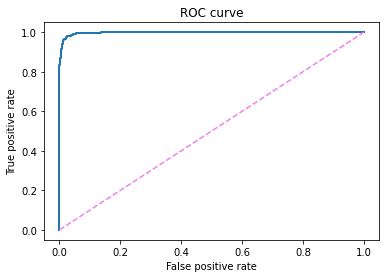

In [21]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba_log))

In [22]:
log_loss(y_test_base, grid_log.predict_proba(X_test_base_scaled))

0.06984885883357397

### K nearest neighbors

In [23]:
knn = KNeighborsClassifier(n_neighbors=1)

In [24]:
knn.fit(X_train_base_scaled,y_train_base)

KNeighborsClassifier(n_neighbors=1)

In [25]:
knn.score(X_test_base_scaled, y_test_base)

0.9260797342192691

In [26]:
pred_knn = knn.predict(X_test_base_scaled)

In [27]:
print(confusion_matrix(y_test_base, pred_knn))

[[647  33]
 [ 56 468]]


In [28]:
print(classification_report(y_test_base, pred_knn))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       680
           1       0.93      0.89      0.91       524

    accuracy                           0.93      1204
   macro avg       0.93      0.92      0.92      1204
weighted avg       0.93      0.93      0.93      1204



#### Choosing a K value

In [29]:
error_rate = []

for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_base_scaled,y_train_base)
    pred_i = knn.predict(X_test_base_scaled)
    error_rate.append(np.mean(pred_i != y_test_base))

Text(0, 0.5, 'Error Rate')

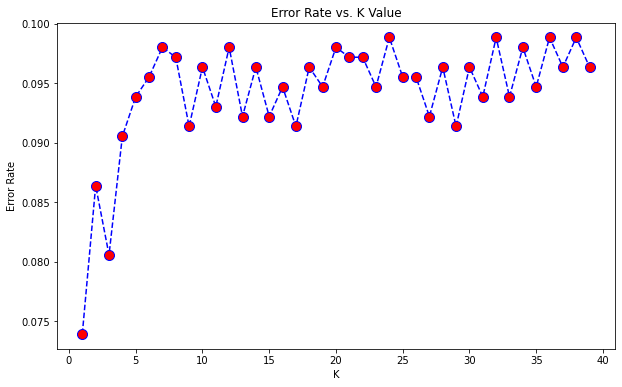

In [30]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

#### Gridsearch

In [31]:
param_grid_knn = {'n_neighbors': range(1,11), 'weights': ['uniform', 'distance'], 'metric': ['euclidean','manhattan']} 

In [32]:
grid_knn = GridSearchCV(KNeighborsClassifier(),param_grid_knn,refit=True,n_jobs=-1,verbose=2)

In [33]:
grid_knn.fit(X_train_base_scaled,y_train_base)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 11),
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [34]:
grid_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

In [35]:
grid_knn.score(X_test_base_scaled, y_test_base)

0.9327242524916943

In [36]:
grid_pred_knn = grid_knn.predict(X_test_base_scaled)

In [37]:
print(confusion_matrix(y_test_base, grid_pred_knn))

[[649  31]
 [ 50 474]]


In [38]:
print(classification_report(y_test_base, grid_pred_knn))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       680
           1       0.94      0.90      0.92       524

    accuracy                           0.93      1204
   macro avg       0.93      0.93      0.93      1204
weighted avg       0.93      0.93      0.93      1204



In [39]:
grid_pred_proba_knn = grid_knn.predict_proba(X_test_base_scaled)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba_knn)

ROC AUC score =  0.9601299393803323


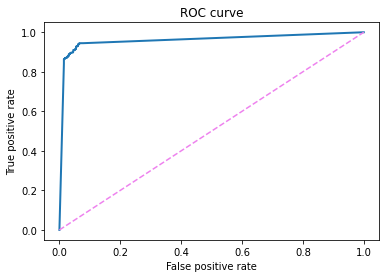

In [40]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba_knn))

In [41]:
log_loss(y_test_base, grid_knn.predict_proba(X_test_base_scaled))

1.172467308944851

### Decision Tree 

In [42]:
dtree = DecisionTreeClassifier()

In [43]:
dtree.fit(X_train_base,y_train_base)

DecisionTreeClassifier()

In [44]:
dtree.score(X_test_base, y_test_base)

0.9634551495016611

In [45]:
pred_dtree = dtree.predict(X_test_base)

In [46]:
print(confusion_matrix(y_test_base, pred_dtree))

[[661  19]
 [ 25 499]]


In [47]:
print(classification_report(y_test_base, pred_dtree))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       680
           1       0.96      0.95      0.96       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



#### Gridsearch

In [48]:
param_grid_dtree = {'criterion': ['gini','entropy'], 'max_depth': range(1,10), 'min_samples_split': range(1,5), 'min_samples_leaf': range(1,5)} 

In [49]:
grid_dtree = GridSearchCV(DecisionTreeClassifier(),param_grid_dtree,refit=True,n_jobs=-1,verbose=2)

In [50]:
grid_dtree.fit(X_train_base,y_train_base)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1357 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    4.0s finished


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5)},
             verbose=2)

In [51]:
grid_dtree.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 3}

In [52]:
grid_dtree.score(X_test_base, y_test_base)

0.9493355481727574

In [53]:
grid_pred_dtree = grid_dtree.predict(X_test_base)

In [54]:
print(confusion_matrix(y_test_base, grid_pred_dtree))

[[671   9]
 [ 52 472]]


In [55]:
print(classification_report(y_test_base, grid_pred_dtree))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       680
           1       0.98      0.90      0.94       524

    accuracy                           0.95      1204
   macro avg       0.95      0.94      0.95      1204
weighted avg       0.95      0.95      0.95      1204



In [56]:
grid_pred_proba_dtree = grid_dtree.predict_proba(X_test_base)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba_dtree)

ROC AUC score =  0.9639565559048046


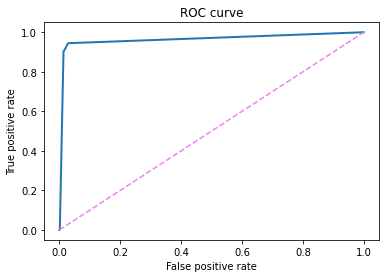

In [57]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba_dtree))

In [58]:
log_loss(y_test_base, grid_dtree.predict_proba(X_test_base))

0.9301021024102011

### Random forest

In [59]:
rfc = RandomForestClassifier()

In [60]:
rfc.fit(X_train_base, y_train_base)

RandomForestClassifier()

In [61]:
rfc.score(X_test_base, y_test_base)

0.9593023255813954

In [62]:
pred_rfc = rfc.predict(X_test_base)

In [63]:
print(confusion_matrix(y_test_base, pred_rfc))

[[665  15]
 [ 34 490]]


In [64]:
print(classification_report(y_test_base, pred_rfc))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       680
           1       0.97      0.94      0.95       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



#### Gridsearch

In [65]:
param_grid_rfc = {'bootstrap': [False],
              'max_depth': [1, 5, 10],
              'max_features': ['auto'],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 3],
              'n_estimators': [50, 100, 200]
             }

In [66]:
grid_rfc = GridSearchCV(RandomForestClassifier(),param_grid_rfc,refit=True,n_jobs=-1,verbose=2)

In [67]:
grid_rfc.fit(X_train_base,y_train_base)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   46.3s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [10, 30, 50],
                         'max_features': ['auto'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [200, 300, 400]},
             verbose=2)

In [68]:
grid_rfc.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [69]:
grid_rfc.score(X_test_base, y_test_base)

0.9559800664451827

In [70]:
grid_pred_rfc = grid_rfc.predict(X_test_base)

In [71]:
print(confusion_matrix(y_test_base, grid_pred_rfc))

[[667  13]
 [ 40 484]]


In [72]:
print(classification_report(y_test_base, grid_pred_rfc))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       680
           1       0.97      0.92      0.95       524

    accuracy                           0.96      1204
   macro avg       0.96      0.95      0.95      1204
weighted avg       0.96      0.96      0.96      1204



In [73]:
grid_pred_proba_rfc = grid_rfc.predict_proba(X_test_base)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba_rfc)

ROC AUC score =  0.9929305118994163


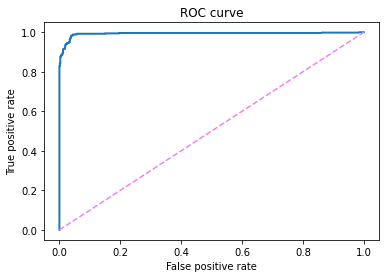

In [74]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba_rfc))

In [75]:
log_loss(y_test_base, grid_rfc.predict_proba(X_test_base))

0.1022456022035494

### Support Vector Machine

In [76]:
svc = SVC()

In [77]:
svc.fit(X_train_base_scaled,y_train_base)

SVC()

In [78]:
svc.score(X_test_base_scaled, y_test_base)

0.957641196013289

In [79]:
pred_svc = svc.predict(X_test_base_scaled)

In [80]:
print(confusion_matrix(y_test_base, pred_svc))

[[660  20]
 [ 31 493]]


In [81]:
print(classification_report(y_test_base, pred_svc))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       680
           1       0.96      0.94      0.95       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



#### Gridsearch

In [82]:
param_grid_svc = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [83]:
grid_svc = GridSearchCV(SVC(),param_grid_svc,refit=True,n_jobs=-1,verbose=2)

In [84]:
grid_svc.fit(X_train_base_scaled,y_train_base)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    4.9s finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

In [85]:
grid_svc.best_params_

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [86]:
grid_svc.score(X_test_base_scaled, y_test_base)

0.9725913621262459

In [87]:
grid_pred_svc = grid_svc.predict(X_test_base_scaled)

In [88]:
print(confusion_matrix(y_test_base, grid_pred_svc))

[[664  16]
 [ 17 507]]


In [89]:
print(classification_report(y_test_base, grid_pred_svc))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       680
           1       0.97      0.97      0.97       524

    accuracy                           0.97      1204
   macro avg       0.97      0.97      0.97      1204
weighted avg       0.97      0.97      0.97      1204



In [90]:
grid_pred_svc = grid_svc.decision_function(X_test_base_scaled)
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_svc)

ROC AUC score =  0.9977211495285138


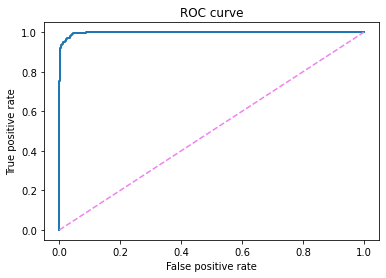

In [91]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_svc))

In [92]:
log_loss(y_test_base, grid_svc.decision_function(X_test_base_scaled))

0.5709213148910454

### Naive Bayes

In [93]:
nb = GaussianNB()

In [94]:
nb.fit(X_train_base, y_train_base)

GaussianNB()

In [95]:
nb.score(X_test_base, y_test_base)

0.6312292358803987

In [96]:
pred_nb = nb.predict(X_test_base)

In [97]:
print(confusion_matrix(y_test_base, pred_nb))

[[635  45]
 [399 125]]


In [98]:
print(classification_report(y_test_base, pred_nb))

              precision    recall  f1-score   support

           0       0.61      0.93      0.74       680
           1       0.74      0.24      0.36       524

    accuracy                           0.63      1204
   macro avg       0.67      0.59      0.55      1204
weighted avg       0.67      0.63      0.58      1204



#### Gridsearch

In [99]:
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

In [100]:
grid_nb = GridSearchCV(GaussianNB(),param_grid_nb,refit=True,n_jobs=-1,verbose=2)

In [101]:
grid_nb.fit(X_train_base,y_train_base)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.6s finished


GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=2)

In [102]:
grid_nb.best_params_

{'var_smoothing': 6.579332246575682e-07}

In [103]:
grid_nb.score(X_test_base, y_test_base)

0.6262458471760798

In [104]:
grid_pred_nb = grid_nb.predict(X_test_base)

In [105]:
print(confusion_matrix(y_test_base, grid_pred_nb))

[[637  43]
 [407 117]]


In [106]:
print(classification_report(y_test_base, grid_pred_nb))

              precision    recall  f1-score   support

           0       0.61      0.94      0.74       680
           1       0.73      0.22      0.34       524

    accuracy                           0.63      1204
   macro avg       0.67      0.58      0.54      1204
weighted avg       0.66      0.63      0.57      1204



In [107]:
grid_pred_proba_nb = grid_nb.predict_proba(X_test_base)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba_nb)

ROC AUC score =  0.6155464189492591


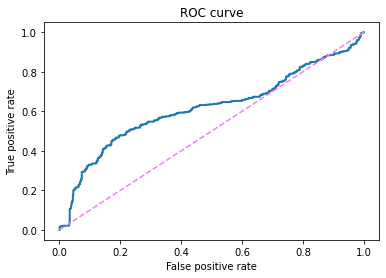

In [108]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba_nb))

In [109]:
log_loss(y_test_base, grid_nb.predict_proba(X_test_base))

1.5423689605525932

### XG Boost

In [110]:
gbm = xgb.XGBClassifier()

In [111]:
gbm.fit(X_train_base, y_train_base)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
gbm.score(X_test_base, y_test_base)

0.9667774086378738

In [113]:
pred_xgb = gbm.predict(X_test_base)

In [114]:
print(confusion_matrix(y_test_base, pred_xgb))

[[668  12]
 [ 28 496]]


In [115]:
print(classification_report(y_test_base, pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       680
           1       0.98      0.95      0.96       524

    accuracy                           0.97      1204
   macro avg       0.97      0.96      0.97      1204
weighted avg       0.97      0.97      0.97      1204



#### Gridsearch

In [116]:
param_grid_xgb = {'n_estimators': [100,1000],  
                  'max_depth': range(1,3),
                  'learning_rate': [0.5,0.75,1],
                  'subsample': np.linspace(0,1,5),
                  'colsample_bytree': np.linspace(0,1,5)
                }

In [117]:
grid_xgb = GridSearchCV(xgb.XGBClassifier(),param_grid_xgb,refit=True,n_jobs=-1,verbose=2)

In [118]:
grid_xgb.fit(X_train_base,y_train_base)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  2.7min finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [119]:
grid_xgb.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.5,
 'max_depth': 2,
 'n_estimators': 100,
 'subsample': 0.5}

In [120]:
grid_xgb.score(X_test_base, y_test_base)

0.957641196013289

In [121]:
grid_pred_xgb = grid_xgb.predict(X_test_base)

In [122]:
print(confusion_matrix(y_test_base, grid_pred_xgb))

[[661  19]
 [ 32 492]]


In [123]:
print(classification_report(y_test_base, grid_pred_xgb))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       680
           1       0.96      0.94      0.95       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



In [124]:
grid_pred_proba_xgb = grid_xgb.predict_proba(X_test_base)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_base, grid_pred_proba_xgb)

ROC AUC score =  0.9939745172878311


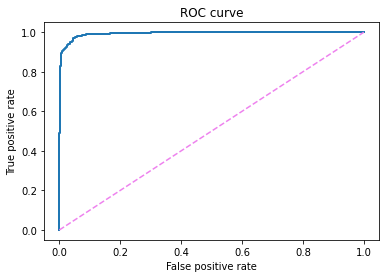

In [125]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_base, grid_pred_proba_xgb))

In [126]:
log_loss(y_test_base, grid_xgb.predict_proba(X_test_base))

0.14897870533873916

## Model 2

In [127]:
df_mf_train2 = pd.read_csv('../Data/df_mf_train2.csv')
df_mf_test2 = pd.read_csv('../Data/df_mf_test2.csv')

In [128]:
df_mf_train2.head()

,Ticker,Dividend Yield (%),Price/Earnings,Price/Cash Flow,Average Market Cap ($ mil),3-year Annualized Return vs. S&P500,Outperform / Underperform
0,VFTNX,1.45,23.37,17.87,183202,4.48,1
1,JCNNX,1.80,22.70,16.71,19870,7.61,1
2,PMJPX,0.68,13.47,4.15,1830,-4.02,0
3,WMICX,2.78,30.72,17.52,1264,23.85,1
4,STAEX,2.02,34.27,24.58,178923,9.69,1


In [129]:
X_train_2 = df_mf_train2.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y_train_2 = df_mf_train2['Outperform / Underperform']

X_test_2 = df_mf_test2.drop(['Ticker','3-year Annualized Return vs. S&P500','Outperform / Underperform'], axis=1)
y_test_2 = df_mf_test2['Outperform / Underperform']

### Logistic regression

In [130]:
scaler = StandardScaler()

In [131]:
X_train_2_scaled = scaler.fit_transform(X_train_2)
X_test_2_scaled = scaler.transform(X_test_2)

#### Gridsearch

In [132]:
param_grid2_log = {'penalty': ['l1','l2'], 'C': [10, 100, 1000, 2000]} 

In [133]:
grid2_log = GridSearchCV(LogisticRegression(),param_grid2_log,refit=True,n_jobs=-1,verbose=2)

In [134]:
grid2_log.fit(X_train_2_scaled,y_train_2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 100, 1000, 2000], 'penalty': ['l1', 'l2']},
             verbose=2)

In [135]:
grid2_log.best_params_

{'C': 100, 'penalty': 'l2'}

In [136]:
grid2_log.score(X_test_2_scaled, y_test_2)

0.9584717607973422

In [ ]:
precision_score(X_test_2_scaled, y_test_2)

In [137]:
grid2_pred_log = grid2_log.predict(X_test_2_scaled)

In [138]:
print(confusion_matrix(y_test_2, grid2_pred_log))

[[665  15]
 [ 35 489]]


In [139]:
print(classification_report(y_test_2, grid2_pred_log))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       680
           1       0.97      0.93      0.95       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



In [140]:
grid2_pred_proba_log = grid2_log.predict_proba(X_test_2_scaled)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_2, grid2_pred_proba_log)

ROC AUC score =  0.9948739896722048


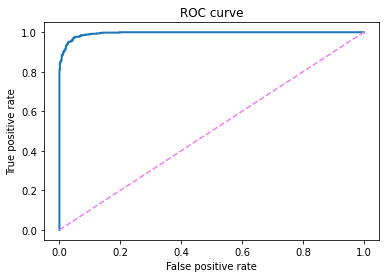

In [141]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_2, grid2_pred_proba_log))

In [142]:
log_loss(y_test_2, grid2_log.predict_proba(X_test_2_scaled))

0.1056923429394837

### K nearest neighbors

#### Gridsearch

In [143]:
param_grid2_knn = {'n_neighbors': list(range(1,5)), 'weights': ['uniform', 'distance'], 'metric': ['euclidean','manhattan']} 

In [144]:
grid2_knn = GridSearchCV(KNeighborsClassifier(),param_grid2_knn,refit=True,n_jobs=-1,verbose=2)

In [145]:
grid2_knn.fit(X_train_2_scaled,y_train_2)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [146]:
grid2_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}

In [147]:
grid2_knn.score(X_test_2_scaled, y_test_2)

0.957641196013289

In [148]:
grid2_pred_knn = grid2_knn.predict(X_test_2_scaled)

In [149]:
print(confusion_matrix(y_test_2, grid2_pred_knn))

[[662  18]
 [ 33 491]]


In [150]:
print(classification_report(y_test_2, grid2_pred_knn))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       680
           1       0.96      0.94      0.95       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



In [151]:
grid2_pred_proba_knn = grid2_knn.predict_proba(X_test_2_scaled)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_2, grid2_pred_proba_knn)

ROC AUC score =  0.9630809384822633


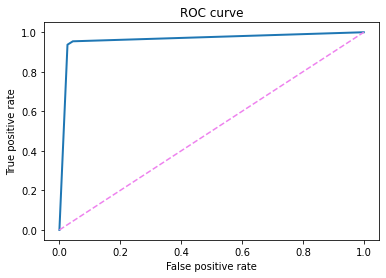

In [152]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_2, grid2_pred_proba_knn))

In [153]:
log_loss(y_test_2, grid2_knn.predict_proba(X_test_2_scaled))

1.2169308134368844

### Decision Tree 

#### Gridsearch

In [154]:
param_grid2_dtree = {'criterion': ['gini','entropy'], 'max_depth': range(1,10), 'min_samples_split': range(1,5), 'min_samples_leaf': range(1,5)} 

In [155]:
grid2_dtree = GridSearchCV(DecisionTreeClassifier(),param_grid2_dtree,refit=True,n_jobs=-1,verbose=2)

In [156]:
grid2_dtree.fit(X_train_2,y_train_2)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    4.8s finished


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 5)},
             verbose=2)

In [157]:
grid2_dtree.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 2,
 'min_samples_split': 3}

In [158]:
grid2_dtree.score(X_test_2, y_test_2)

0.9476744186046512

In [159]:
grid2_pred_dtree = grid2_dtree.predict(X_test_2)

In [160]:
print(confusion_matrix(y_test_2, grid2_pred_dtree))

[[656  24]
 [ 39 485]]


In [161]:
print(classification_report(y_test_2, grid2_pred_dtree))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       680
           1       0.95      0.93      0.94       524

    accuracy                           0.95      1204
   macro avg       0.95      0.95      0.95      1204
weighted avg       0.95      0.95      0.95      1204



In [162]:
grid2_pred_proba_dtree = grid2_dtree.predict_proba(X_test_2)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_2, grid2_pred_proba_dtree)

ROC AUC score =  0.9531502581948811


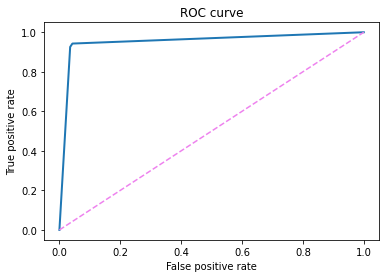

In [163]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_2, grid2_pred_proba_dtree))

In [164]:
log_loss(y_test_2, grid2_dtree.predict_proba(X_test_2))

1.5571411842633032

### Random forest

#### Gridsearch

In [165]:
param_grid2_rfc = {'bootstrap': [False],
              'max_depth': [10, 30, 50],
              'max_features': ['auto'],
              'min_samples_leaf': [1, 2],
              'min_samples_split': [2, 3],
              'n_estimators': [100, 200, 300]
             }

In [166]:
grid2_rfc = GridSearchCV(RandomForestClassifier(),param_grid2_rfc,refit=True,n_jobs=-1,verbose=2)

In [167]:
grid2_rfc.fit(X_train_2,y_train_2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   19.5s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [10, 30, 50],
                         'max_features': ['auto'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [168]:
grid2_rfc.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [169]:
grid2_rfc.score(X_test_2, y_test_2)

0.9493355481727574

In [170]:
grid2_pred_rfc = grid2_rfc.predict(X_test_2)

In [171]:
print(confusion_matrix(y_test_2, grid2_pred_rfc))

[[664  16]
 [ 45 479]]


In [172]:
print(classification_report(y_test_2, grid2_pred_rfc))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       680
           1       0.97      0.91      0.94       524

    accuracy                           0.95      1204
   macro avg       0.95      0.95      0.95      1204
weighted avg       0.95      0.95      0.95      1204



In [173]:
grid2_pred_proba_rfc = grid2_rfc.predict_proba(X_test_2)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_2, grid2_pred_proba_rfc)

ROC AUC score =  0.987728726986978


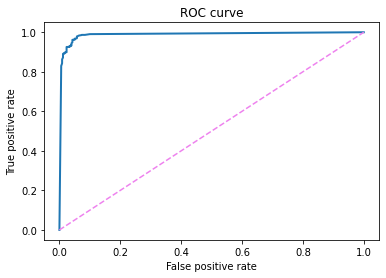

In [174]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_2, grid2_pred_proba_rfc))

In [175]:
log_loss(y_test_2, grid2_rfc.predict_proba(X_test_2))

0.3754957578672606

### Support Vector Machine

#### Gridsearch

In [176]:
param_grid2_svc = {'C': [100, 1000, 5000, 10000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [177]:
grid2_svc = GridSearchCV(SVC(),param_grid2_svc,refit=True,n_jobs=-1,verbose=2)

In [178]:
grid2_svc.fit(X_train_2_scaled,y_train_2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [100, 1000, 5000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=2)

In [179]:
grid2_svc.best_params_

{'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}

In [180]:
grid2_svc.score(X_test_2_scaled, y_test_2)

0.9634551495016611

In [181]:
grid2_pred_svc = grid2_svc.predict(X_test_2_scaled)

In [182]:
print(confusion_matrix(y_test_2, grid2_pred_svc))

[[665  15]
 [ 29 495]]


In [183]:
print(classification_report(y_test_2, grid2_pred_svc))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       680
           1       0.97      0.94      0.96       524

    accuracy                           0.96      1204
   macro avg       0.96      0.96      0.96      1204
weighted avg       0.96      0.96      0.96      1204



In [184]:
grid2_pred_svc = grid2_svc.decision_function(X_test_2_scaled)
fpr, tpr, thresoholds = roc_curve(y_test_2, grid2_pred_svc)

ROC AUC score =  0.9950283453075887


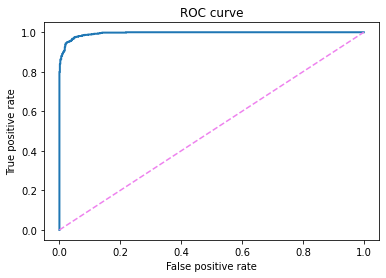

In [185]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_2, grid2_pred_svc))

In [186]:
log_loss(y_test_2, grid2_svc.decision_function(X_test_2_scaled))

0.9379509643998699

### Naive Bayes

#### Gridsearch

In [187]:
param_grid2_nb = {'var_smoothing': np.logspace(0,-20, 50)}

In [188]:
grid2_nb = GridSearchCV(GaussianNB(),param_grid2_nb,refit=True,n_jobs=-1,verbose=2)

In [189]:
grid2_nb.fit(X_train_2,y_train_2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.9s finished


GridSearchCV(estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 3.90693994e-01, 1.52641797e-01, 5.96362332e-02,
       2.32995181e-02, 9.10298178e-03, 3.55648031e-03, 1.38949549e-03,
       5.42867544e-04, 2.12095089e-04, 8.28642773e-05, 3.23745754e-05,
       1.26485522e-05, 4.94171336e-06, 1.93069773e-06, 7.54312006e-07,
       2.94705170e-07, 1.15139540e-07...
       1.59985872e-10, 6.25055193e-11, 2.44205309e-11, 9.54095476e-12,
       3.72759372e-12, 1.45634848e-12, 5.68986603e-13, 2.22299648e-13,
       8.68511374e-14, 3.39322177e-14, 1.32571137e-14, 5.17947468e-15,
       2.02358965e-15, 7.90604321e-16, 3.08884360e-16, 1.20679264e-16,
       4.71486636e-17, 1.84206997e-17, 7.19685673e-18, 2.81176870e-18,
       1.09854114e-18, 4.29193426e-19, 1.67683294e-19, 6.55128557e-20,
       2.55954792e-20, 1.00000000e-20])},
             verbose=2)

In [190]:
grid2_nb.best_params_

{'var_smoothing': 3.39322177189533e-14}

In [191]:
grid2_nb.score(X_test_2, y_test_2)

0.9136212624584718

In [192]:
grid2_pred_nb = grid2_nb.predict(X_test_2)

In [193]:
print(confusion_matrix(y_test_2, grid2_pred_nb))

[[631  49]
 [ 55 469]]


In [194]:
print(classification_report(y_test_2, grid2_pred_nb))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       680
           1       0.91      0.90      0.90       524

    accuracy                           0.91      1204
   macro avg       0.91      0.91      0.91      1204
weighted avg       0.91      0.91      0.91      1204



In [195]:
grid2_pred_proba_nb = grid2_nb.predict_proba(X_test_2)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_2, grid2_pred_proba_nb)

ROC AUC score =  0.9709937696452627


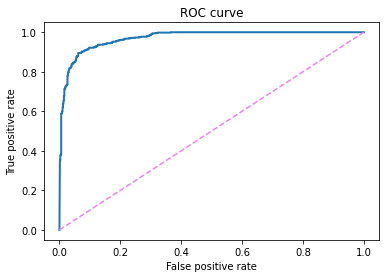

In [196]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_2, grid2_pred_proba_nb))

In [197]:
log_loss(y_test_2, grid2_nb.predict_proba(X_test_2))

0.4255805974833264

### XG Boost

#### Gridsearch

In [198]:
param_grid2_xgb = {'n_estimators': [100,1000],  
                  'max_depth': range(1,3),
                  'learning_rate': [0.5,0.75,1],
                  'subsample': np.linspace(0,1,5),
                  'colsample_bytree': np.linspace(0,1,5)
                }

In [199]:
grid2_xgb = GridSearchCV(xgb.XGBClassifier(),param_grid2_xgb,refit=True,n_jobs=-1,verbose=2)

In [200]:
grid2_xgb.fit(X_train_2,y_train_2)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 397 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 680 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 1045 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  1.5min finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [201]:
grid2_xgb.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.75,
 'max_depth': 2,
 'n_estimators': 1000,
 'subsample': 0.25}

In [202]:
grid2_xgb.score(X_test_2, y_test_2)

0.9493355481727574

In [203]:
grid2_pred_xgb = grid2_xgb.predict(X_test_2)

In [204]:
print(confusion_matrix(y_test_2, grid2_pred_xgb))

[[663  17]
 [ 44 480]]


In [205]:
print(classification_report(y_test_2, grid2_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       680
           1       0.97      0.92      0.94       524

    accuracy                           0.95      1204
   macro avg       0.95      0.95      0.95      1204
weighted avg       0.95      0.95      0.95      1204



In [206]:
grid2_pred_proba_xgb = grid2_xgb.predict_proba(X_test_2)[:,1]
fpr, tpr, thresoholds = roc_curve(y_test_2, grid2_pred_proba_xgb)

ROC AUC score =  0.9873596766951055


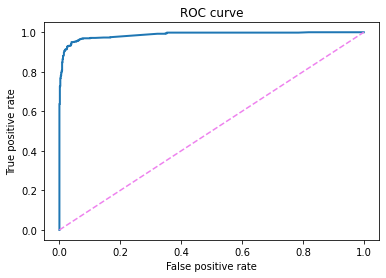

In [207]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test_2, grid2_pred_proba_xgb))

In [208]:
log_loss(y_test_2, grid2_xgb.predict_proba(X_test_2))

0.22391413912705382